本指南使用机器学习按种类对鸢尾花进行分类。它使用TensorFlow进行以下操作：1.建立模型，2.在示例数据上训练该模型，并3.使用模型对未知数据进行预测。

TensorFlow编程
本指南使用以下高级TensorFlow概念：

* 使用TensorFlow的默认渴望执行开发环境，
* 使用Datasets API导入数据，
* 使用TensorFlow的Keras API构建模型和层。

本教程的结构类似于许多TensorFlow程序：

1. 导入并解析数据集。
1. 选择模型的类型。
2. 训练模型。
3. 评估模型的有效性。
4. 使用训练有素的模型进行预测。

安装程序

配置导入

导入TensorFlow和其他必需的Python模块。默认情况下，TensorFlow使用急切执行立即评估操作，返回具体值，而不是创建稍后执行的计算图。如果您习惯于REPL或python交互式控制台，则感觉很熟悉。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.0.0
Eager execution: True


花瓣分类问题
想象一下，您是一位植物学家，正在寻找一种自动化的方法来对找到的每种鸢尾花进行分类。机器学习提供了许多算法来对花朵进行统计分类。例如，复杂的机器学习程序可以根据照片对花朵进行分类。我们的野心更加温和-我们将基于鸢尾花的萼片和花瓣的长度和宽度测量对其进行分类。

鸢尾属大约有300种，但是我们的程序仅对以下三种进行分类：

鸢尾鸢尾<br>
鸢尾<br>
杂色鸢尾<br>


幸运的是，已经有人用萼片和花瓣的测量值创建了120个鸢尾花的数据集。这是一个经典数据集，在初学者机器学习分类问题中很流行。

导入并解析训练数据集<br>
下载数据集文件并将其转换为该Python程序可以使用的结构。

下载数据集<br>
使用tf.keras.utils.get_file函数下载训练数据集文件。这将返回下载文件的文件路径：

In [4]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 1s 146us/step
Local copy of the dataset file: C:\Users\sha\.keras\datasets\iris_training.csv


该数据集iris_training.csv是一个纯文本文件，用于存储格式为逗号分隔值（CSV）的表格数据。

从数据集的此视图中，注意以下几点：

1. 第一行是包含有关数据集信息的标题：
    * 共有120个示例。每个示例均具有四个功能以及三个可能的标签名称之一。
2. 随后的行是数据记录，每行一个示例，其中：
    * 前四个字段是功能：这些是示例的功能。在此，字段包含代表花朵尺寸的浮点数。
    * 最后一列是标签：这是我们要预测的值。对于此数据集，它是与花名相对应的0、1或2的整数值。

让我们用代码写出来：

In [5]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


每个标签都与字符串名称相关联（例如，“ setosa”），但是机器学习通常依赖于数值。标签编号映射到命名表示形式，例如：

* 0：鸢尾花
* 1：鸢尾花
* 2：鸢尾

有关功能和标签的更多信息，请参阅机器学习速成课程的ML术语部分。

In [6]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [7]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


该make_csv_dataset函数返回tf.data.Dataset的(features, label)对，其中features是一个字典：{'feature_name': value}

这些Dataset对象是可迭代的。让我们看一下一批功能：

In [8]:
features, labels = next(iter(train_dataset))

print(features)

OrderedDict([('sepal_length', <tf.Tensor: id=68, shape=(32,), dtype=float32, numpy=
array([4.9, 5.8, 6.1, 5. , 5.7, 5.4, 6.3, 5.8, 6.1, 7.2, 5.2, 5.5, 5.5,
       6.8, 5.7, 6.6, 6.4, 7.3, 6.4, 5.8, 7.7, 7.2, 4.6, 4.4, 5. , 5.8,
       5.5, 5.1, 6.9, 4.6, 5.1, 5.9], dtype=float32)>), ('sepal_width', <tf.Tensor: id=69, shape=(32,), dtype=float32, numpy=
array([3.1, 2.7, 3. , 3. , 3. , 3.9, 3.3, 2.8, 2.9, 3.2, 3.5, 2.6, 2.4,
       3.2, 4.4, 3. , 3.1, 2.9, 2.8, 4. , 3.8, 3. , 3.1, 2.9, 3.4, 2.6,
       3.5, 3.8, 3.1, 3.4, 2.5, 3. ], dtype=float32)>), ('petal_length', <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
array([1.5, 4.1, 4.9, 1.6, 4.2, 1.7, 6. , 5.1, 4.7, 6. , 1.5, 4.4, 3.8,
       5.9, 1.5, 4.4, 5.5, 6.3, 5.6, 1.2, 6.7, 5.8, 1.5, 1.4, 1.6, 4. ,
       1.3, 1.9, 5.1, 1.4, 3. , 5.1], dtype=float32)>), ('petal_width', <tf.Tensor: id=67, shape=(32,), dtype=float32, numpy=
array([0.1, 1. , 1.8, 0.2, 1.2, 0.4, 2.5, 2.4, 1.4, 1.8, 0.2, 1.2, 1.1,
       2.3, 0.4, 1.4, 1.8, 1.8, 2

请注意，相似功能被组合在一起或成批处理。每个示例行的字段都附加到相应的要素数组。更改batch_size以设置存储在这些要素数组中的示例数。

您可以通过绘制批处理中的一些功能来开始查看一些群集：

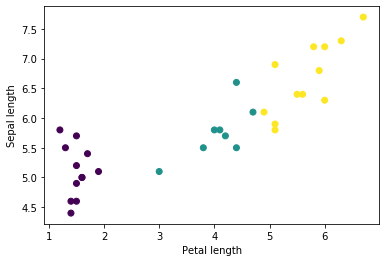

In [9]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

为了简化模型构建步骤，请创建一个函数以将特征字典重新打包为一个形状为的单个数组(batch_size, num_features)。

此函数使用tf.stack方法，该方法从张量列表中获取值，并在指定的维上创建组合张量：

In [10]:
def pack_features_vector(features, labels):
    """Pack the features into a single array."""
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

然后使用tf.data.Dataset.map方法将features每(features,label)对数据包打包到训练数据集中：

In [11]:
train_dataset = train_dataset.map(pack_features_vector)

现在的features元素Dataset是具有shape的数组(batch_size, num_features)。让我们看一下前几个例子：

In [12]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[6.4 2.7 5.3 1.9]
 [5.2 2.7 3.9 1.4]
 [5.  3.5 1.3 0.3]
 [4.7 3.2 1.6 0.2]
 [6.9 3.1 5.1 2.3]], shape=(5, 4), dtype=float32)


选择型号类型<br>
为什么要模型？<br>
一个模型是功能和标签之间的关系。对于虹膜分类问题，模型定义了萼片和花瓣测量值与预测的虹膜种类之间的关系。一些简单的模型可以用几行代数来描述，但是复杂的机器学习模型具有大量难以概括的参数。

您能否在不使用机器学习的情况下确定这四个特征与虹膜物种之间的关系？也就是说，您可以使用传统的编程技术（例如，很多条件语句）来创建模型吗？也许-如果您对数据集进行足够长的分析，以确定特定物种的花瓣和萼片测量值之间的关系。在更复杂的数据集上，这变得困难（甚至不可能）。好的机器学习方法可以为您确定模型。如果您将足够的代表性示例输入正确的机器学习模型类型，则程序将为您找出关系。

选择型号<br>
我们需要选择要训练的模型。有很多类型的模型，挑选一个好的模型需要经验。本教程使用神经网络解决虹膜分类问题。神经网络可以找到特征和标签之间的复杂关系。它是一种高度结构化的图，分为一个或多个隐藏层。每个隐藏层由一个或多个神经元组成。神经网络分为几类，该程序使用密集的或完全连接的神经网络：一层中的神经元从每个神经元接收输入连接。前一层的神经元。例如，图2说明了一个密集的神经网络，它由一个输入层，两个隐藏层和一个输出层组成：

![11](https://tensorflow.google.cn/images/custom_estimators/full_network.png)

当训练来自图2的模型并提供一个未标记的示例时，它得出三个预测：该花是给定的鸢尾花物种的可能性。这种预测称为推断。对于此示例，输出预测的总和为1.0。在图2中，此预测分解为：0.02对于鸢尾鸢尾，0.95对于鸢尾鸢尾和0.03对弗吉尼亚鸢尾。这意味着该模型以95％的概率预测未标记的示例花是鸢尾花。

使用Keras创建模型<br>
TensorFlow tf.keras API是创建模型和图层的首选方法。这使得在Keras处理将所有内容连接在一起的复杂性时，可以轻松地构建模型和进行实验。

该tf.keras.Sequential模型是层的线性堆栈。它的构造函数获取一个层实例的列表，在这种情况下，是两个Dense层（每个10个节点），以及一个输出层（具有3个节点）代表我们的标签预测。第一层的input_shape参数与数据集中的要素数量相对应，并且是必需的：

In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

的激活函数确定在层中的每个节点的输出形状。这些非线性很重要-没有它们，模型将等效于单个层。有许多可用的激活，但是ReLU在隐藏层中很常见。

隐藏层和神经元的理想数量取决于问题和数据集。像机器学习的许多方面一样，选择最佳形状的神经网络需要知识和实验的混合。根据经验，增加隐藏层和神经元的数量通常会创建一个更强大的模型，该模型需要更多数据才能有效训练。

使用模型<br>
让我们快速看一下该模型对一批功能的作用：

In [14]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=231, shape=(5, 3), dtype=float32, numpy=
array([[-0.29860798,  0.23763543,  0.20006706],
       [-0.2183184 ,  0.1506175 ,  0.1280839 ],
       [ 0.0117741 , -0.01999016,  0.06204171],
       [-0.05206833,  0.01564752,  0.0317561 ],
       [-0.20953804,  0.21855035,  0.18113638]], dtype=float32)>

在这里，每个示例都会为每个类返回一个logit。

要将这些对数转换为每个类的概率，请使用softmax函数：

In [15]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=236, shape=(5, 3), dtype=float32, numpy=
array([[0.22956255, 0.3924539 , 0.37798354],
       [0.2590562 , 0.37464577, 0.36629805],
       [0.33109432, 0.3207426 , 0.34816307],
       [0.31670633, 0.33889514, 0.3443985 ],
       [0.24923368, 0.38240466, 0.3683617 ]], dtype=float32)>

进行tf.argmax跨类学习可以给我们预测的类索引。但是，该模型尚未经过训练，因此这些不是很好的预测：

In [16]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 2 2 1 1 1 2 1 2 1 1 2 2 1 1 1 1 1 1 2 1 1 2 1 1 2 2 1 1 1 1]
    Labels: [2 1 0 0 2 2 1 0 1 0 2 2 0 0 1 2 2 2 1 2 0 1 2 0 2 1 0 0 2 2 2 1]


训练模型<br>
训练是模型逐步优化或模型学习数据集时机器学习的阶段。目标是充分了解训练数据集的结构，以便对看不见的数据进行预测。如果您对训练数据集了解太多，那么预测仅适用于它所看到的数据，并且不能被推广。这个问题称为过拟合 -就像记住答案，而不是理解如何解决问题。

Iris分类问题是监督式机器学习的一个示例：该模型是从包含标签的示例中训练出来的。在无监督机器学习中，示例不包含标签。取而代之的是，模型通常会在特征之间找到模式。

定义损耗和梯度函数<br>
训练和评估阶段都需要计算模型的损失。这可以衡量模型的预测与期望标签之间的距离，换句话说，模型的性能有多差。我们要最小化或优化此值。

我们的模型将使用该tf.keras.losses.SparseCategoricalCrossentropy函数来计算其损失，该函数采用模型的类别概率预测和所需标签，然后返回示例中的平均损失。

In [17]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [18]:
def loss(model, x, y):
    y_ = model(x)

    return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.0166196823120117


使用tf.GradientTape上下文来计算用于优化模型的梯度：

In [19]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

创建一个优化器<br>
一个优化应用计算的梯度到模型中的变量，以最小化loss功能。您可以将损失函数视为曲面（请参见图3），我们希望通过走动来找到其最低点。梯度指向最陡峭的上升方向-因此我们将以相反的方式行进并下山。通过迭代计算每批的损失和梯度，我们将在训练期间调整模型。该模型将逐步找到权重和偏差的最佳组合，以最大程度地减少损失。损失越小，模型的预测越好。

![Pandao editor.md](https://cs231n.github.io/assets/nn3/opt1.gif)

TensorFlow有许多可用于训练的优化算法。此模型使用实现随机梯度下降（SGD）算法的tf.train.GradientDescentOptimizer。该步长，以便对每个组迭代下山。这是一个超参数，您通常会对其进行调整以获得更好的结果。learning_rate

让我们设置优化器：

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

我们将使用它来计算单个优化步骤：

In [21]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.0166196823120117
Step: 1,         Loss: 0.9872187972068787


训练循环
所有零件都准备就绪，模型就可以进行训练了！训练循环将数据集示例输入模型，以帮助其做出更好的预测。以下代码块设置了这些训练步骤：

1. 重复每个时期。历元是数据集的一次遍历。
2. 在一个纪元内，遍历训练中的每个示例并Dataset抓住其特征（x）和标签（y）。
3. 使用示例的功能，进行预测并将其与标签进行比较。测量预测的不准确性，并使用该误差来计算模型的损失和梯度。
4. 使用optimizer来更新模型的变量。
5. 跟踪一些统计数据以进行可视化。
6. 对每个时期重复一次。

该num_epochs变量是次遍历数据集的收集数量。违反直觉，训练更长的模型并不能保证有更好的模型。num_epochs是您可以调整的超参数。选择合适的电话号码通常需要经验和实验：

In [22]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        epoch_accuracy(y, model(x))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.987, Accuracy: 35.000%
Epoch 050: Loss: 0.083, Accuracy: 97.500%
Epoch 100: Loss: 0.074, Accuracy: 96.667%
Epoch 150: Loss: 0.064, Accuracy: 97.500%
Epoch 200: Loss: 0.049, Accuracy: 99.167%


随时间可视化损失函数

虽然打印出模型的训练进度会有所帮助，但查看此进度通常会更有帮助。TensorBoard是TensorFlow 附带的一个很好的可视化工具，但是我们可以使用该matplotlib模块创建基本图表。

解释这些图表需要一些经验，但是您确实希望看到损失下降而准确性上升：

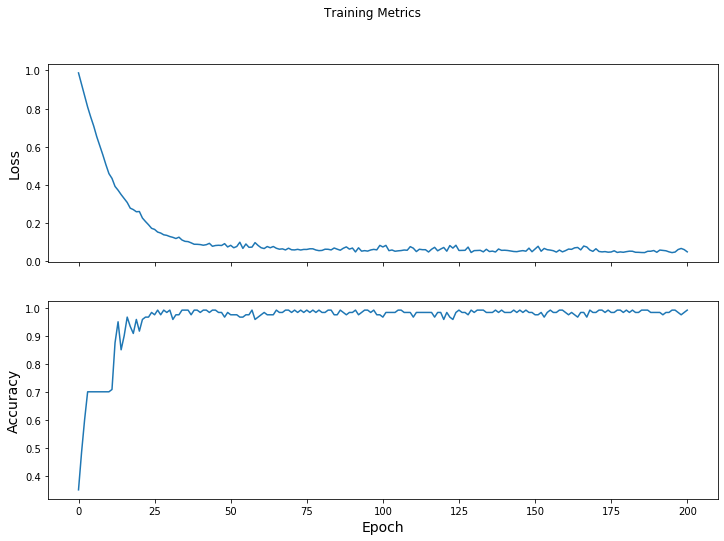

In [23]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

评估模型的有效性
现在已经对模型进行了训练，我们可以获得有关其性能的一些统计信息。

评估意味着确定模型进行预测的效率。要确定虹膜分类时模型的有效性，请将一些萼片和花瓣的测量值传递给模型，并要求模型预测它们代表的虹膜种类。然后将模型的预测与实际标签进行比较。

设置测试数据集<br>
评估模型类似于训练模型。最大的不同是示例来自单独的测试集而不是训练集。为了公平地评估模型的有效性，用于评估模型的示例必须与用于训练模型的示例不同。

测试Dataset的设置类似于训练的设置Dataset。下载CSV文本文件并解析该值，然后对其进行一些随机播放：

In [24]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


在测试数据集上评估模型<br>
与训练阶段不同，该模型仅评估单个时期的测试数据。在下面的代码单元中，我们遍历测试集中的每个示例，并将模型的预测与实际标签进行比较。这用于衡量整个测试集中模型的准确性：

In [25]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

In [26]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
    logits = model(x)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


例如，我们可以在最后一批中看到该模型通常是正确的：

In [27]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: id=115075, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 1],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]])>

使用训练有素的模型进行预测<br>
我们已经训练了一个模型，并“证明”了该模型在对虹膜物种进行分类方面是很好的，但还不是完美的。现在，让我们使用训练有素的模型对未标记的示例进行一些预测；也就是说，在包含功能但不包含标签的示例中。

在现实生活中，未标记的示例可能来自许多不同的来源，包括应用程序，CSV文件和数据馈送。目前，我们将手动提供三个未标记的示例来预测其标记。回想一下，标签号映射到一个命名表示形式，如下所示：

* 0：鸢尾花
* 1：鸢尾花
* 2：鸢尾

In [28]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (100.0%)
Example 1 prediction: Iris versicolor (99.9%)
Example 2 prediction: Iris virginica (98.0%)
